# Parametric ROMs

See previous *HDM.ipynb for the high fidelity model description and optimization. From now on, 
I show the ROM results here.

In [1]:
# load the regular HDM (although we won't directly use it here until later for error comparisons)
# now let's test this out and visualize it
import sys, numpy as np
sys.path.append("utils/beam-fea")
from solver import BeamFem

E = 2e7; b = 4e-3; L = 1; rho = 1
qmag = 2e-2
ys = 4e5

# scaling inputs
# if rho_KS was too high like 500, then the constraint was too nonlinear or close to max and optimization failed
rho_KS = 50.0 # rho = 50 for 100 elements, used 500 later
# try 30 elements and 30 modes at one point
# nxe = num_elements = int(300) #100, 300, 1e3
nxe = int(3e2)
nxh = 10 # num designs

hvec = np.array([1e-3] * nxh)

beam_fea = BeamFem(nxe, nxh, E, b, L, rho, qmag, ys, rho_KS, dense=False)

# can show how slow the solution might be for higher # elements
# beam_fea.solve_forward(hvec)
# beam_fea.plot_disp()

pod_rel_err=4.6290898026096443e-10


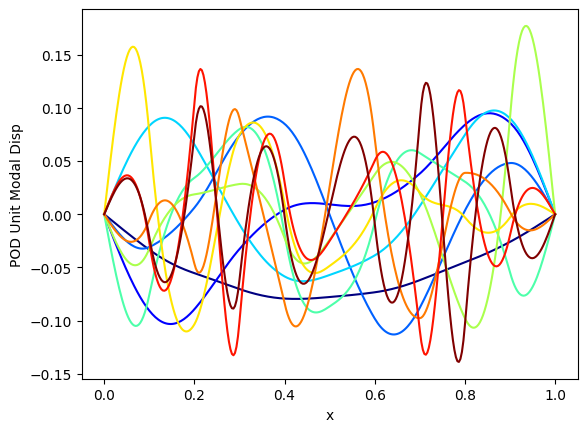

In [2]:
# now let's use the hyper-reduced order model strategy to 
# speedup the structural optimization
# based on Farhat, https://link.springer.com/article/10.1007/s00158-014-1183-y?sa_campaign=email%2Fevent%2FarticleAuthor%2FonlineFirst

# here since I'm using a linear beam, I don't have to do the hyper-ROM step (only necessary for nonlinear models)
# and you want to collect snapshots of resid vector at intermediate convergence steps.. not final conv. (but this is not clear in the literature)
from rom_solver import BeamFemRom

beam_rom = BeamFemRom.from_HDM(beam_fea)
lb = np.array([5e-4]*nxh)
ub = np.array([3e-3]*nxh)
hvec0 = hvec

# here using latin hypercube method to train param ROM
# maybe will get lower stresses with greedy ROM that learns during optimization?
# can do fewer designs and higher rank but concerned about higher stress issue with fewer samples
# need a new strategy to handle optimization with stress-constr here and POD I suspect
hvec_list = beam_rom.gen_param_list(lb, ub, hvec0, num_designs=100)
# print(f"{len(hvec_list)=}")
# tried 3, 30, nxe modes (with fewer modes than DVs rn bc DVs = nxe)
# I get overdetermined optim problem and it doesn't work well, maybe I should
# add a regularization term on DVs to smooth it out when overdetermined?
beam_rom.offline_ROM_training(hvec_list, rank=10) #30
beam_rom.plot_pod_modes()

# check V is orthonormal
# VTV = beam_rom.V.T @ beam_rom.V
# print(f"{VTV=}")

funcs=array([2.40000000e+04, 3.65878336e+00])


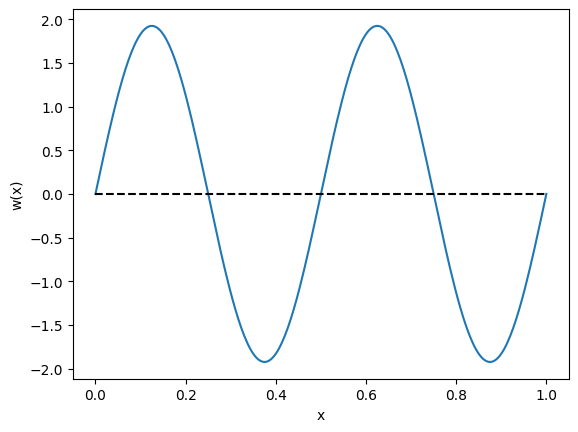

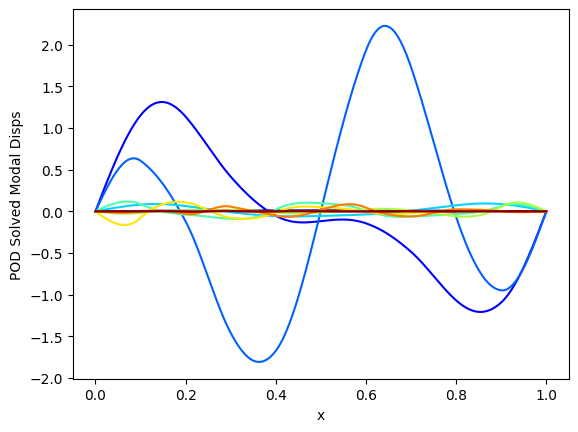

In [3]:
# test derivatives and ROM solve
beam_rom.solve_forward(hvec)
# print(f"{beam_rom.uhat=}")
beam_rom.solve_adjoint(hvec)
funcs = beam_rom.get_functions(hvec)
func_grads = beam_rom.get_function_gradients(hvec)

print(f"{funcs=}")
# print(f"{func_grads[:,:10]=}")

# complex step passed, here for debug if needed
# beam_rom.complex_step_test(hvec)
# beam_rom.solve_forward(hvec) # solve again in reals

# also plot displacement solved from ROM
beam_rom.plot_disp()

# need some kind of smoothing step over the POD modes to reduce stress singularities?
# why is stress so much higher? This may be a bad sign for this work.. if POD modes have
# much higher stresses a lot, maybe need higher KS and to change sampling strategy 
# for the POD modes to reduce influence of lower order modes for high stresses?
beam_rom.plot_pod_disps(num_plot=10)

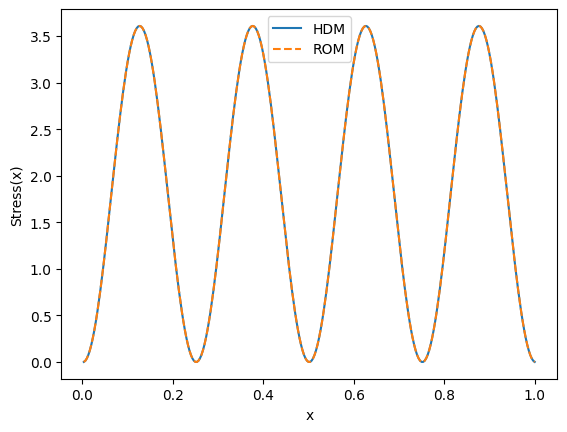

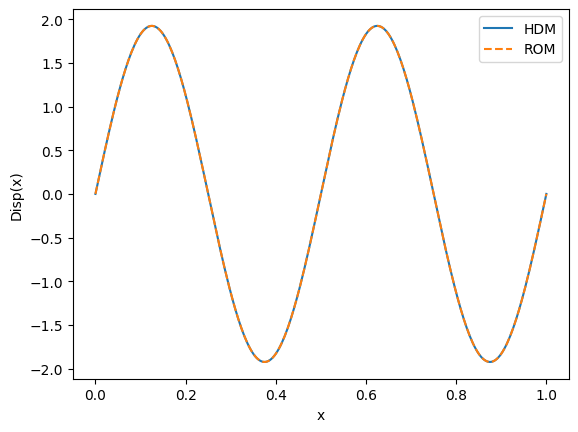

In [4]:
# why did we get different stress from the HDM?
beam_rom.plot_stresses(hvec)
beam_rom.plot_disp_compare(hvec)

# maybe I could use a GP model or a smoothing model to predict the true stress field from reduced stress field or something?
# this is tricky here..

# TODO : use a RBF-GP to smooth stress field? this way you can still do preliminary design optimization well..
# this would happen in the plate problem too..

# could do hyperparameter optimization of the GP to recover stress fields with appropriate length-scales more accurately
# or we could use ANN ML model? TBD on this, I think GP is better though since it's non-parametric and this is really a smoothing step we need.

In [5]:
# optimize over this
"""
optimization over POD model of the beam
I am concerned that the design may not be allowed to deviate too far from main POD modes
without introducing high stresses or low energy modes?
Then this may give us a different design or much heavier design, but let's try it.

Maybe we can use ML to correct some low-energy stresses? TBD on this..
"""

# then we'll apply this in an optimization problem with HDM (high fidelity)
# from scipy.optimize import minimize, NonlinearConstraint
from pyoptsparse import SNOPT, Optimization
import os

run_full_opt = True
use_regularization = True

# problem is I had to tune the regularization parameter here
# and that is tricky => how to know how to do this correctly..
# this prevents overfitting
reg_scale = 5e8

def objfunc(xdict):
    x = xdict["x"]
    # print(f"{x=}")
    beam_rom.solve_forward(x)
    funcs = beam_rom.get_functions(x)
    # print(f"{funcs=}")

    regularization = reg_scale * np.sum( (np.diff(x))**2)
    print(f"{regularization=}")

    funcs = {
        "obj" : funcs[0] + use_regularization * regularization,
        "stress" : funcs[1],
    }
    return funcs, False

def sens(xdict, funcs):
    x = xdict["x"]
    beam_rom.solve_adjoint(x)
    func_grads = beam_rom.get_function_gradients(x)

    regularization_grad = np.array([0.0] * nxe)
    for ielem in range(nxe):
        if ielem == 0:
            regularization_grad[ielem] += 2.0 * reg_scale * (x[ielem] - x[ielem+1])
        elif ielem == nxe - 1:
            regularization_grad[ielem] += 2.0 * reg_scale * (x[ielem] - x[ielem-1])
        else:
            regularization_grad[ielem] += 2.0 * reg_scale * (2.0 * x[ielem] - x[ielem-1] - x[ielem+1])

    funcsSens = {
        "obj" : { "x" : func_grads[0,:] +  use_regularization * regularization_grad},
        "stress" : { "x" : func_grads[1,:]},
    }
    return funcsSens, False

# Optimization Object
optProb = Optimization("Beam HFD opt", objfunc)

# Design Variables
x0 = hvec
optProb.addVarGroup("x", nxe, lower=1e-4, upper=None, value=hvec, scale=100.0)

# Functions
optProb.addObj("obj", scale=1e-2)
optProb.addCon("stress", upper=1.0)

# Check optimization problem:
# print(optProb)

# Optimizer
# these are some really good SNOPT settings (use these)
SNOPT_options = {
    "Print frequency": 1000,
    "Summary frequency": 10000000,
    "Major feasibility tolerance": 1e-6,
    "Major optimality tolerance": 1e-4,
    "Verify level": 0,
    "Major iterations limit": 15000 if run_full_opt else 10,
    "Minor iterations limit": 150000000,
    "Iterations limit": 100000000,
    # "Major step limit": 5e-2, # had this off I think (but this maybe could be on)
    "Nonderivative linesearch": True,  # turns off derivative linesearch
    "Linesearch tolerance": 0.9,
    "Difference interval": 1e-6,
    "Function precision": 1e-10,
    "New superbasics limit": 2000,
    "Penalty parameter": 1.0,  # had this off for faster opt in the single panel case
    # however ksfailure becomes too large with this off. W/ on merit function goes down too slowly though
    # try intermediate value btw 0 and 1 (smaller penalty)
    # this may be the most important switch to change for opt performance w/ ksfailure in the opt
    # TODO : could try higher penalty parameter like 50 or higher and see if that helps reduce iteration count..
    #   because it often increases the penalty parameter a lot near the optimal solution anyways
    "Scale option": 1,
    "Hessian updates": 40,
    'Proximal iterations limit' : 0, # turn this off so it doesn't clip linear bounds
    "Print file": os.path.join(f"SNOPT_ROM_print.out"),
    "Summary file": os.path.join(f"SNOPT_ROM_summary.out"),
}
opt = SNOPT(options=SNOPT_options)
sol = opt(optProb, sens=sens)

# Check Solution
print(sol)


+------------------------------------------------------------------------------+
| pyOptSparse Error: The 'value' argument is invalid. It must be None, a       |
| scalar, or a list/array or length 300.                                       |
+------------------------------------------------------------------------------+



Error: The 'value' argument is invalid. It must be None, a scalar, or a list/array or length 300.

In [ ]:
# show the final thickness distribution
hvec_opt = sol.xStar['x']
# print(hvec_opt)
beam_rom.plot_thickness(hvec_opt)

"""
problem is we get really high stresses because we point evaluate it..
should we also compute a reduction on the thickness DVs so that we can optimize 
more smoothly over this? use GP to smooth stress field or GP to model DVs from red DVs?

NOTE : this optimization problem becomes over-determined (if numDVs > numModes) =>
leads to poor optimization result. What to do with this?
When only 3 modes were retained, the optimization only optimized 3 or 4 DVs

It worked really well with regularization and nxe = num_modes?
now try regularization and num_modes << nxe
But now all the DVs are active essentially..

NOTE : this would probably work better on lower # DVs such as shape vars
"""

# also the final deformation
beam_rom.plot_disp()